# Forecasting Consensus Expectations: Consumer Price Index (CPI)
## Data Exploration

In [57]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.dates as mdates
import statsmodels.api as sm
import plotly.express as px

from tqdm.auto import tqdm
from scipy import stats, special
from scipy.optimize import brentq
from collections import defaultdict
from itertools import product
from scipy.stats import t as student_t, norm, binomtest, jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan

**Read**

In [58]:
OUT_DIR = "../out"        
MOM_DF_FILE       = "cpi_mom_df.parquet"
MOM_DF_FULL_FILE  = "cpi_mom_df_full.parquet"
YOY_DF_FILE       = "cpi_yoy_df.parquet"
YOY_DF_FULL_FILE  = "cpi_yoy_df_full.parquet"

mom_df       = pd.read_parquet(os.path.join(OUT_DIR, MOM_DF_FILE),      engine="pyarrow")
mom_df_full  = pd.read_parquet(os.path.join(OUT_DIR, MOM_DF_FULL_FILE), engine="pyarrow")

yoy_df       = pd.read_parquet(os.path.join(OUT_DIR, YOY_DF_FILE),      engine="pyarrow")
yoy_df_full  = pd.read_parquet(os.path.join(OUT_DIR, YOY_DF_FULL_FILE), engine="pyarrow")

print("mom_df shape     :", mom_df.shape)
print("mom_df_full shape:", mom_df_full.shape)

print("yoy_df shape     :", yoy_df.shape)
print("yoy_df_full shape:", yoy_df_full.shape)

mom_df shape     : (50347, 11)
mom_df_full shape: (59455, 11)
yoy_df shape     : (32238, 11)
yoy_df_full shape: (38070, 11)


In [59]:
mom_df.head()

,release_date,period,median_survey,actual,economist,firm,forecast,asof,error,surprise,series
0,2006-01-18,2005-12-31,0.2000,0.2000,Adam Chester,Lloyds Bank PLC,NaN,NaT,NaN,0.0000,Core CPI M/M
1,2006-01-18,2005-12-31,0.2000,0.2000,Alessandro Truppia,Aletti Gestielle Sgr Spa,NaN,NaT,NaN,0.0000,Core CPI M/M
2,2006-01-18,2005-12-31,0.2000,0.2000,Alison Lynn Reaser,Point Loma Nazarene University,0.2000,2006-01-16,0.0000,0.0000,Core CPI M/M
3,2006-01-18,2005-12-31,0.2000,0.2000,Allan Von Mehren,Danske Bank AS,NaN,NaT,NaN,0.0000,Core CPI M/M
4,2006-01-18,2005-12-31,0.2000,0.2000,Andreas Busch,Bantleon AG,0.2000,2006-01-16,0.0000,0.0000,Core CPI M/M


In [60]:
mom_df_full.head()

,release_date,period,median_survey,actual,economist,firm,forecast,asof,error,surprise,series
0,2006-01-18,2005-12-31,0.2000,0.2000,Adam Chester,Lloyds Bank PLC,NaN,NaT,NaN,0.0000,Core CPI M/M
1,2006-01-18,2005-12-31,0.2000,0.2000,Alessandro Truppia,Aletti Gestielle Sgr Spa,NaN,NaT,NaN,0.0000,Core CPI M/M
2,2006-01-18,2005-12-31,0.2000,0.2000,Alison Lynn Reaser,Point Loma Nazarene University,0.2000,2006-01-16,0.0000,0.0000,Core CPI M/M
3,2006-01-18,2005-12-31,0.2000,0.2000,Allan Von Mehren,Danske Bank AS,NaN,NaT,NaN,0.0000,Core CPI M/M
4,2006-01-18,2005-12-31,0.2000,0.2000,Andreas Busch,Bantleon AG,0.2000,2006-01-16,0.0000,0.0000,Core CPI M/M


In [61]:
yoy_df.head()

,release_date,period,median_survey,actual,economist,firm,forecast,asof,error,surprise,series
0,2006-01-18,2005-12-31,2.2000,2.2000,Adam Chester,Lloyds Bank PLC,NaN,NaT,NaN,0.0000,Core CPI Y/Y
1,2006-01-18,2005-12-31,2.2000,2.2000,Allan Von Mehren,Danske Bank AS,NaN,NaT,NaN,0.0000,Core CPI Y/Y
2,2006-01-18,2005-12-31,2.2000,2.2000,Andreas Busch,Bantleon AG,NaN,NaT,NaN,0.0000,Core CPI Y/Y
3,2006-01-18,2005-12-31,2.2000,2.2000,Andrew Gretzinger,Manulife Asset Management Limited,NaN,NaT,NaN,0.0000,Core CPI Y/Y
4,2006-01-18,2005-12-31,2.2000,2.2000,Aneta Markowska,Moore Capital Management LP,NaN,NaT,NaN,0.0000,Core CPI Y/Y


In [62]:
yoy_df_full.head()

,release_date,period,median_survey,actual,economist,firm,forecast,asof,error,surprise,series
0,2006-01-18,2005-12-31,2.2000,2.2000,Adam Chester,Lloyds Bank PLC,NaN,NaT,NaN,0.0000,Core CPI Y/Y
1,2006-01-18,2005-12-31,2.2000,2.2000,Allan Von Mehren,Danske Bank AS,NaN,NaT,NaN,0.0000,Core CPI Y/Y
2,2006-01-18,2005-12-31,2.2000,2.2000,Andreas Busch,Bantleon AG,NaN,NaT,NaN,0.0000,Core CPI Y/Y
3,2006-01-18,2005-12-31,2.2000,2.2000,Andrew Gretzinger,Manulife Asset Management Limited,NaN,NaT,NaN,0.0000,Core CPI Y/Y
4,2006-01-18,2005-12-31,2.2000,2.2000,Aneta Markowska,Moore Capital Management LP,NaN,NaT,NaN,0.0000,Core CPI Y/Y


**Explore**

In [63]:
plt.style.use("seaborn-v0_8-whitegrid")  
# -------------------------------------------------------------------------
# Helper: generate one-row-per-release table (median vs actual)
# -------------------------------------------------------------------------
def median_vs_actual(df_full: pd.DataFrame, window=6):
    tbl = (df_full.groupby("release_date")
                    .agg(crowd_median=("forecast", "median"),
                         actual      =("actual",   "first"))
                    .dropna()
                    .sort_index())
    tbl["err"] = tbl["crowd_median"] - tbl["actual"]
    tbl[f"rmse_{window}m"] = (tbl["err"]
                              .rolling(window, min_periods=window)
                              .apply(lambda x: np.sqrt(np.mean(x**2)),
                                     raw=True))
    return tbl

# -------------------------------------------------------------------------
# Helper: distribution diagnostics (hist + QQ + normality tests)
# -------------------------------------------------------------------------
def dist_diagnostics(errors: np.ndarray, title_prefix=""):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(errors, bins=50, edgecolor="k", ax=axs[0])
    axs[0].set_title(f"{title_prefix}Error histogram")
    axs[0].set_xlabel("Error"); axs[0].set_ylabel("Freq")

    # --- FIXED: give a distribution object, not a string --------------
    sm.qqplot(errors, dist=stats.norm, line="s", ax=axs[1])
    axs[1].set_title(f"{title_prefix}QQ-plot vs Normal")

    plt.tight_layout(); plt.show()

    jb_stat, jb_p = st.jarque_bera(errors)
    nu, loc, scale = st.t.fit(errors)
    ks_stat, ks_p  = st.kstest(errors, "t", args=(nu, loc, scale))

    print(f"{title_prefix}Jarque-Bera   : JB = {jb_stat:,.1f}, p = {jb_p:.4f}")
    print(f"{title_prefix}Student-t fit : ν = {nu:4.1f}, "
          f"KS p-value = {ks_p:.4f}\n")


# -------------------------------------------------------------------------
# Helper: cross-section spread vs |median error|
# -------------------------------------------------------------------------
def spread_vs_error(df_panel: pd.DataFrame, label=""):
    spread = (df_panel.groupby("release_date")["forecast"].std(ddof=0)
                        .rename("spread"))
    med_err = (df_panel.groupby("release_date")
                          .apply(lambda d: 
                                 (d["median_survey"].iloc[0] - d["actual"].iloc[0]))
                          .rename("median_err").abs())
    tbl = pd.concat([spread, med_err], axis=1).dropna()

    sns.regplot(data=tbl, x="spread", y="median_err", scatter_kws={"alpha":0.6})
    plt.title(f"Cross-section spread vs |Median error| ({label})")
    plt.xlabel("Forecast SD"); plt.ylabel("|Median error|")
    plt.tight_layout(); plt.show()

    pearson = tbl.corr(method="pearson").loc["spread","median_err"]
    spearman = tbl.corr(method="spearman").loc["spread","median_err"]
    print(f"{label} ρ_Pearson  = {pearson:6.3f}")
    print(f"{label} ρ_Spearman = {spearman:6.3f}\n")

# -------------------------------------------------------------------------
# Helper: active economist count with contiguity rule
# -------------------------------------------------------------------------
def active_economists(df_full: pd.DataFrame, windows=(6,12,24)):
    dates = np.sort(df_full["release_date"].unique())
    active = {}

    for W in windows:
        counts = []
        for i in range(W, len(dates)):
            slc = df_full[df_full["release_date"].isin(dates[i-W:i])]
            ok  = slc.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
            counts.append((dates[i], ok.sum()))
        active[W] = pd.Series({d:c for d,c in counts})

    plt.figure(figsize=(10,4))
    for W, s in active.items():
        plt.plot(s.index, s.values, marker="o", label=f"{W}-mo")
    plt.title("Active economists per release (contiguity filter)")
    plt.xlabel("Release date"); plt.ylabel("# Economists")
    plt.legend(); plt.tight_layout(); plt.show()



========== Core CPI M/M ==========


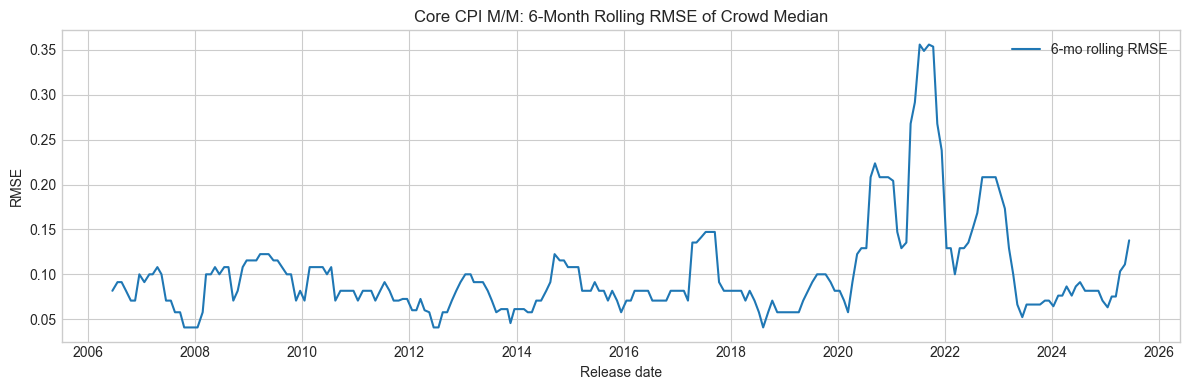

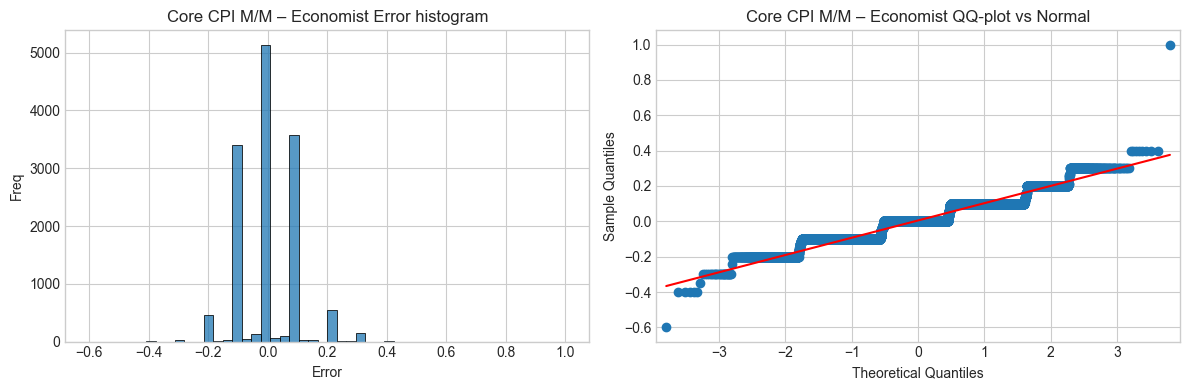

Core CPI M/M – Economist Jarque-Bera   : JB = 810.8, p = 0.0000
Core CPI M/M – Economist Student-t fit : ν = 23.0, KS p-value = 0.0000



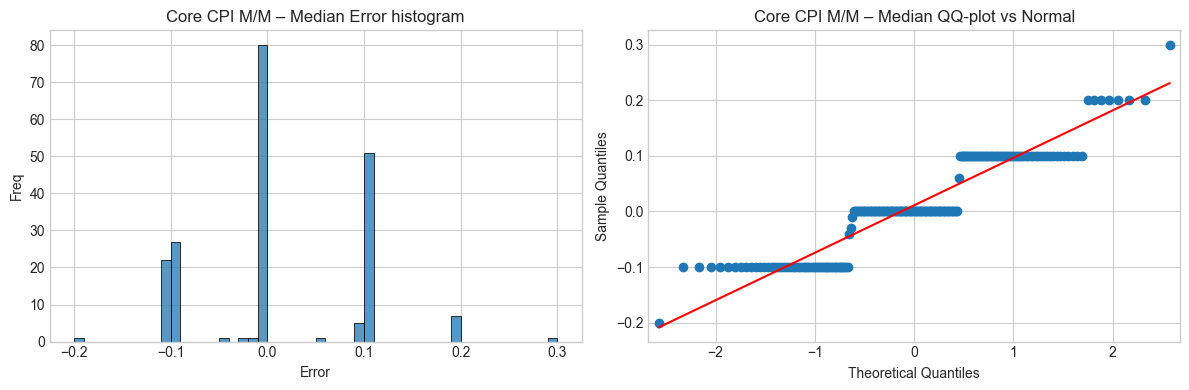

Core CPI M/M – Median Jarque-Bera   : JB = 3.1, p = 0.2145
Core CPI M/M – Median Student-t fit : ν = 197167490.7, KS p-value = 0.0000



C:\Users\nwong\AppData\Local\Temp\ipykernel_22952\2017207694.py:50: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d:


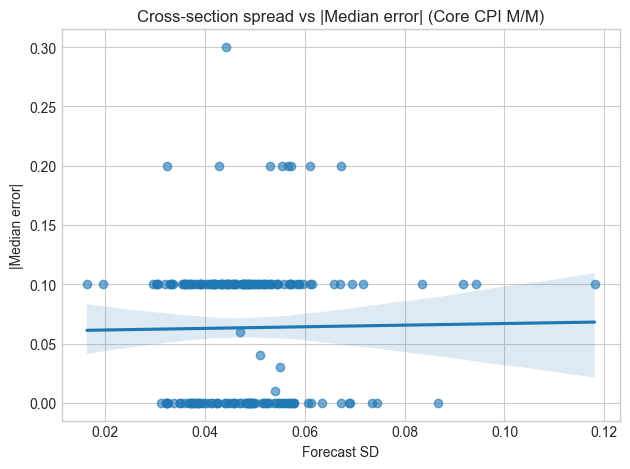

Core CPI M/M ρ_Pearson  =  0.015
Core CPI M/M ρ_Spearman =  0.014



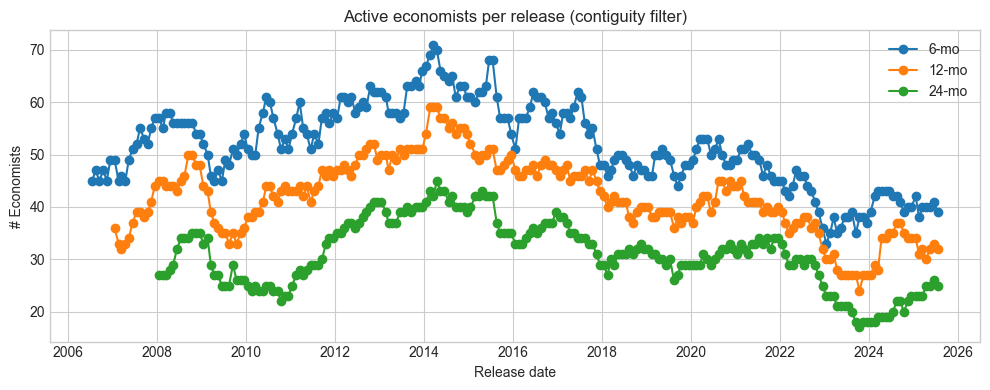


========== Core CPI Y/Y ==========


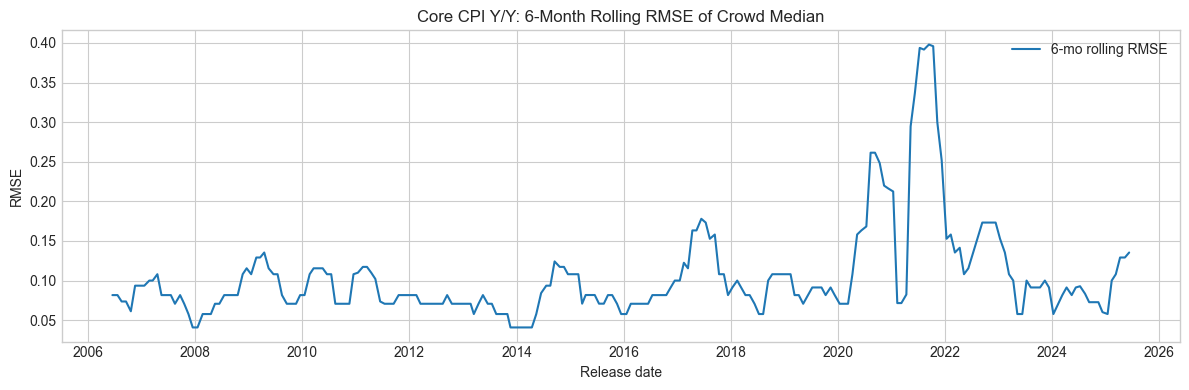

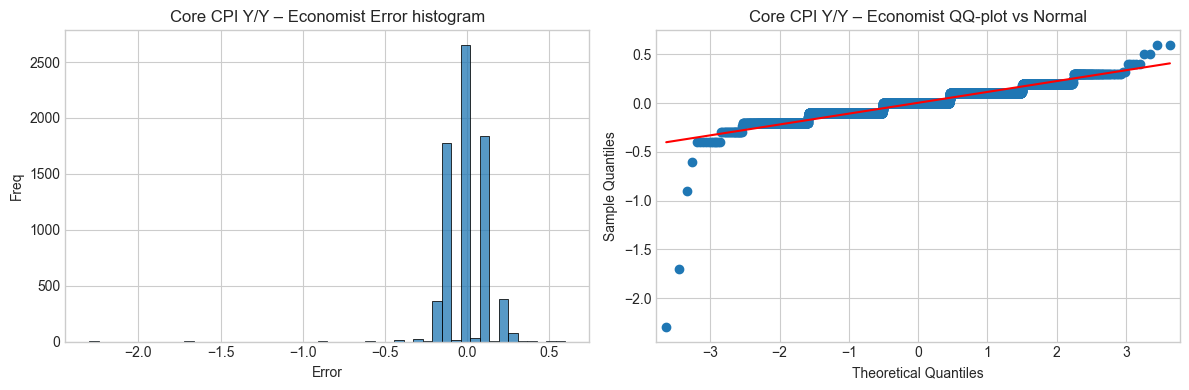

Core CPI Y/Y – Economist Jarque-Bera   : JB = 346,170.8, p = 0.0000
Core CPI Y/Y – Economist Student-t fit : ν = 11.1, KS p-value = 0.0000



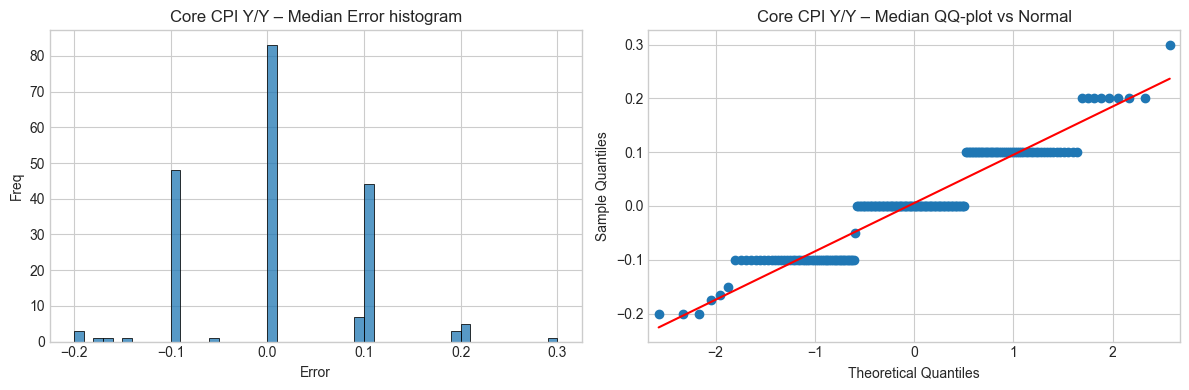

Core CPI Y/Y – Median Jarque-Bera   : JB = 1.7, p = 0.4295
Core CPI Y/Y – Median Student-t fit : ν = 25966373375.8, KS p-value = 0.0000



C:\Users\nwong\AppData\Local\Temp\ipykernel_22952\2017207694.py:50: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d:


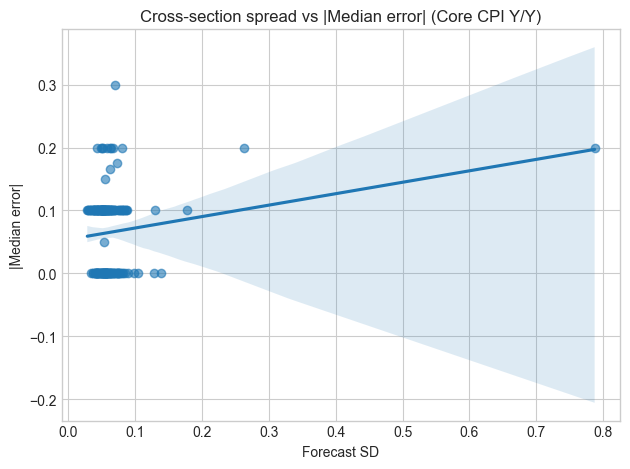

Core CPI Y/Y ρ_Pearson  =  0.167
Core CPI Y/Y ρ_Spearman = -0.023



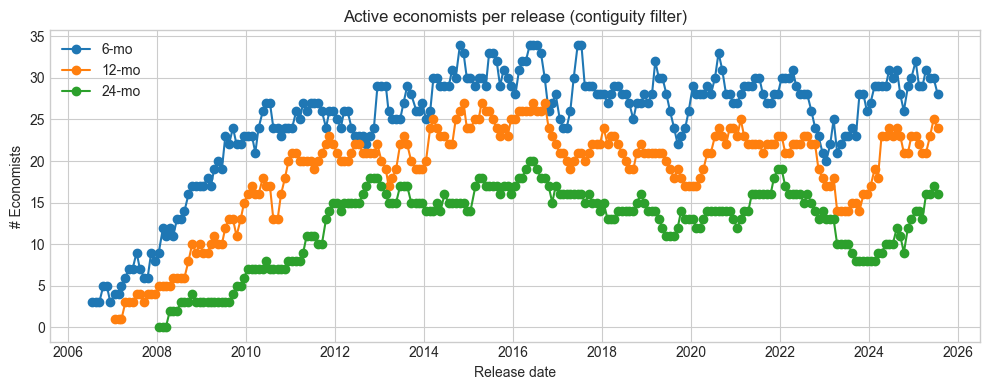

In [64]:
PANELS = {
    "Core CPI M/M": {"df": mom_df, "df_full": mom_df_full},
    "Core CPI Y/Y": {"df": yoy_df, "df_full": yoy_df_full},
}

for name, d in PANELS.items():
    print(f"\n========== {name} ==========")

    df, df_full = d["df"], d["df_full"]

    # 1. Rolling RMSE of crowd median
    mv_tbl = median_vs_actual(df_full, window=6)
    plt.figure(figsize=(12,4))
    plt.plot(mv_tbl.index, mv_tbl["rmse_6m"], label="6-mo rolling RMSE")
    plt.title(f"{name}: 6-Month Rolling RMSE of Crowd Median")
    plt.xlabel("Release date"); plt.ylabel("RMSE"); plt.legend(); plt.tight_layout(); plt.show()

    # 2. Economist-level error diagnostics
    errors_econ = df["error"].dropna().values
    dist_diagnostics(errors_econ, title_prefix=f"{name} – Economist ")

    # 3. Median-forecast error diagnostics
    med_errors = (df
                  .drop_duplicates("release_date")
                  .assign(med_err=lambda d: d["median_survey"] - d["actual"])
                  ["med_err"].dropna().values)
    dist_diagnostics(med_errors, title_prefix=f"{name} – Median ")

    # 4. Cross-section spread vs |median error|
    spread_vs_error(df, label=name)

    # 5. Active forecaster counts
    active_economists(df_full)

In [65]:
# --- compute absolute error and sort ----------------------------
yoy_df_full["abs_error"] = yoy_df_full["forecast"] - yoy_df_full["actual"]
yoy_df_full["abs_error"] = yoy_df_full["abs_error"].abs()

top_misses = (yoy_df_full
              .dropna(subset=["forecast", "actual"])      # keep rows with forecasts
              .sort_values("abs_error", ascending=False)  # largest miss first
              .head(10)                                    # top-5
              .loc[:, ["release_date", "economist", "firm",
                       "forecast", "actual", "error", "abs_error"]])

# --- nicer formatting -------------------------------------------
pd.set_option("display.float_format", "{:.4f}".format)
print("\nTop-5 largest forecast misses (Core CPI Y/Y)")
display(top_misses)



Top-5 largest forecast misses (Core CPI Y/Y)


,release_date,economist,firm,forecast,actual,error,abs_error
1727,2006-11-16,Michael R Englund,Action Economics LLC,0.4000,2.7000,-2.3000,2.3000
6007,2009-02-20,Bernd Krampen,Nord LB,0.0000,1.7000,-1.7000,1.7000
32246,2022-08-10,Augustine Faucher,PNC Finl Services Group INC,4.9000,5.9000,-1.0000,1.0000
32025,2022-06-10,Mikael Olai Milhoj,Sterna Capital Partners,5.0000,6.0000,-1.0000,1.0000
8233,2010-03-18,Ryan Wang,HSBC Securities USA Inc,0.4000,1.3000,-0.9000,0.9000
29877,2021-05-12,Jean/Genereux,Desjardins Financial Group,2.1000,3.0000,-0.9000,0.9000
29944,2021-05-12,Scott J Brown,Raymond James Financial Inc,2.1000,3.0000,-0.9000,0.9000
29850,2021-05-12,David William Berson,Nationwide Insurance,2.2000,3.0000,-0.8000,0.8000
29821,2021-05-12,Bernd Krampen,Nord LB,2.2000,3.0000,-0.8000,0.8000
29822,2021-05-12,Besch/Luetje,Dekabank Deutsche Girozentrale,2.2000,3.0000,-0.8000,0.8000


In [66]:
yoy_df_full[
    (yoy_df_full['economist'] == 'Paolo Mameli') &
    (yoy_df_full['forecast'].notna())
]

,release_date,period,median_survey,actual,economist,firm,forecast,asof,error,surprise,series,abs_error


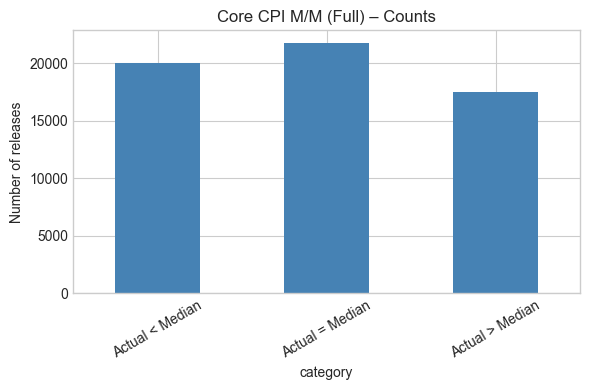

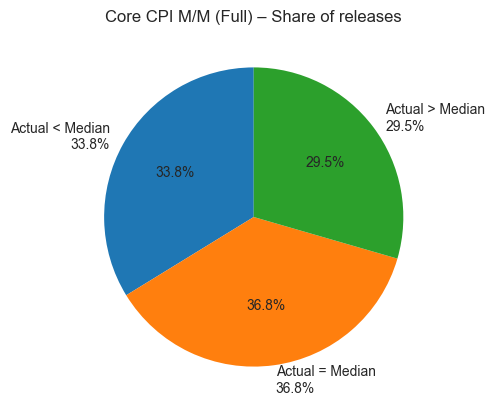

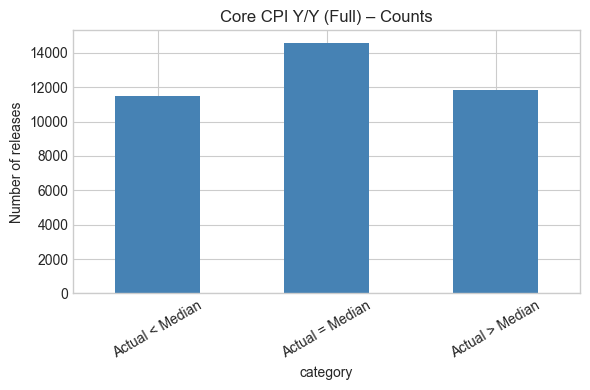

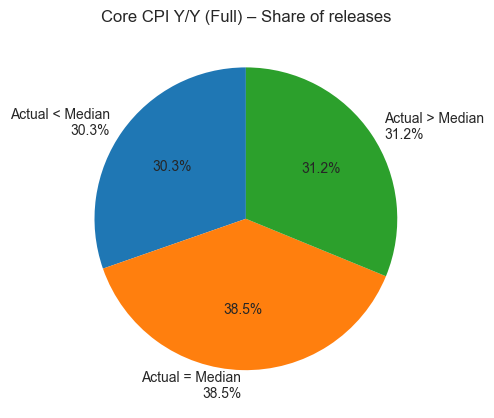

In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_direction_counts(df: pd.DataFrame, title: str):
    """
    • Bar‑chart the counts of releases where
        actual < median_survey,
        actual = median_survey,
        actual > median_survey
    • Pie‑chart the same breakdown as % of total releases
    """
    subset = df.dropna(subset=["actual", "median_survey"]).copy()

    # classify each release (string labels ⇒ avoids dtype issues)
    subset["category"] = np.where(
        subset["actual"] < subset["median_survey"],  "Actual < Median",
        np.where(subset["actual"] > subset["median_survey"],
                 "Actual > Median",
                 "Actual = Median")
    )

    labels_order = ["Actual < Median", "Actual = Median", "Actual > Median"]
    counts = (subset["category"]
              .value_counts()
              .reindex(labels_order, fill_value=0))

    # ─── BAR CHART ───────────────────────────────────────────────
    counts.plot.bar(figsize=(6, 4), rot=30, color="steelblue")
    plt.title(title + " – Counts")
    plt.ylabel("Number of releases")
    plt.tight_layout()
    plt.show()

    # ─── PIE CHART (percent of total) ───────────────────────────
    plt.figure(figsize=(5, 5))
    plt.pie(
        counts.values,
        labels=[f"{lab}\n{val/len(subset):.1%}" for lab, val in zip(labels_order, counts.values)],
        autopct="%1.1f%%",
        startangle=90
    )
    plt.title(title + " – Share of releases")
    plt.tight_layout()
    plt.show()


# -----------------------------------------------------
plot_direction_counts(mom_df_full, "Core CPI M/M (Full)")
plot_direction_counts(yoy_df_full, "Core CPI Y/Y (Full)")



===== Core CPI M/M (Full): spread descriptive stats =====


,count,mean,median,std
category,,,,
Actual < Median,79,0.0535,0.0476,0.0221
Actual = Median,86,0.0494,0.0488,0.0138
Actual > Median,69,0.0554,0.0512,0.0206


Welch t-test  equal vs < :  t= -1.40, p=0.1635
Welch t-test  equal vs > :  t= -2.06, p=0.0418


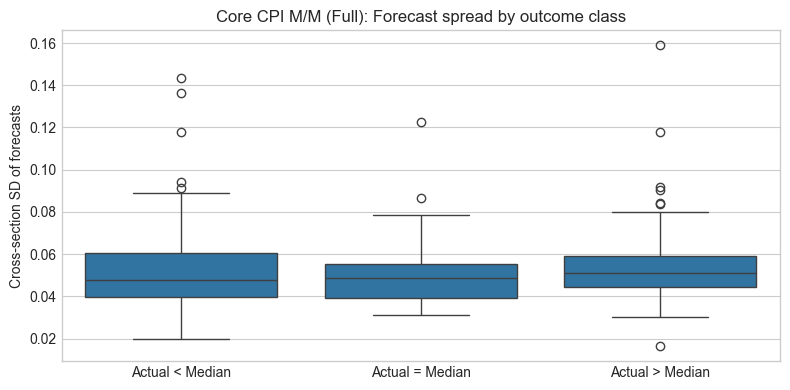

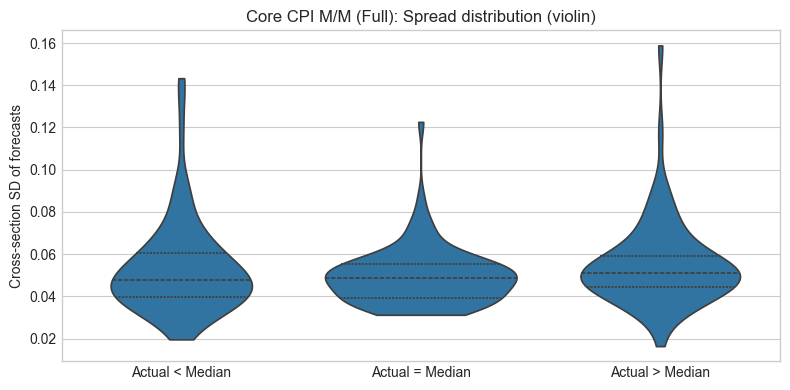


===== Core CPI Y/Y (Full): spread descriptive stats =====


,count,mean,median,std
category,,,,
Actual < Median,71,0.0756,0.0572,0.0916
Actual = Median,90,0.0631,0.0573,0.0227
Actual > Median,73,0.0673,0.0577,0.0335


Welch t-test  equal vs < :  t= -1.12, p=0.2655
Welch t-test  equal vs > :  t= -0.90, p=0.3692


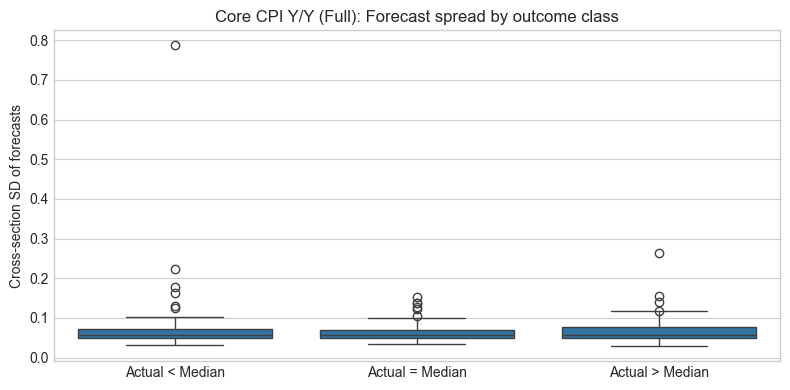

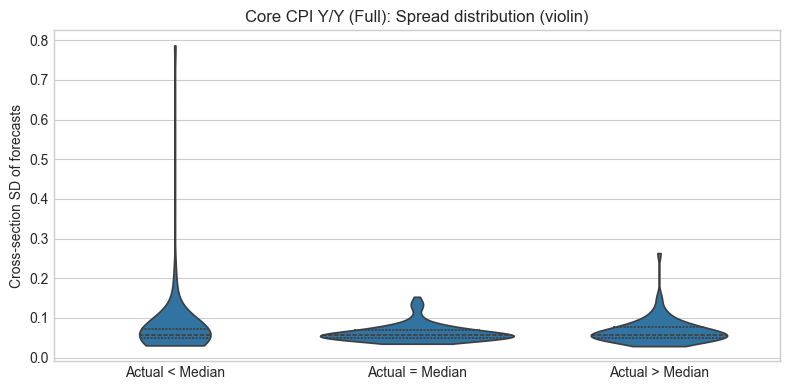

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# ------------------------------------------------------------
# helper: analyse one panel
# ------------------------------------------------------------
def analyse_deadzone(df_full: pd.DataFrame,
                     panel_name: str,
                     median_col: str = "median_survey") -> None:
    """
    • Creates a three-way class (actual <>== median)
    • Summarises cross-section forecast spread (SD)
    • Welch t-tests: 'equal' vs tails
    • Plots box + violin
    """
    # --- cross-section spread per release --------------------
    spread = (df_full.groupby("release_date")["forecast"]
                     .std(ddof=0)
                     .rename("spread"))

    # --- median & actual per release -------------------------
    mid_tbl = (df_full.drop_duplicates("release_date")
                        .set_index("release_date")[["actual", median_col]]
                        .rename(columns={median_col: "median"}))

    tbl = (mid_tbl.join(spread, how="inner")
                   .dropna(subset=["actual", "median", "spread"]))

    # --- classify releases -----------------------------------
    tbl["category"] = np.where(
        tbl["actual"] < tbl["median"],  "Actual < Median",
        np.where(tbl["actual"] > tbl["median"],
                 "Actual > Median",
                 "Actual = Median")
    )

    # --- descriptive stats -----------------------------------
    desc = (tbl.groupby("category")["spread"]
                .agg(["count", "mean", "median", "std"])
                .reindex(["Actual < Median",
                          "Actual = Median",
                          "Actual > Median"]))
    print(f"\n===== {panel_name}: spread descriptive stats =====")
    display(desc)

    # --- pairwise Welch t-tests ------------------------------
    cats = {c: tbl.loc[tbl["category"] == c, "spread"].values
            for c in tbl["category"].unique()}
    for tail in ("Actual < Median", "Actual > Median"):
        if {"Actual = Median", tail}.issubset(cats):
            t, p = stats.ttest_ind(cats["Actual = Median"],
                                   cats[tail],
                                   equal_var=False, nan_policy="omit")
            print(f"Welch t-test  equal vs {tail.split()[1]} :  t={t:6.2f}, p={p:.4f}")

    # --- box-plot --------------------------------------------
    order = ["Actual < Median", "Actual = Median", "Actual > Median"]
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=tbl, x="category", y="spread", order=order)
    plt.title(f"{panel_name}: Forecast spread by outcome class")
    plt.ylabel("Cross-section SD of forecasts"); plt.xlabel("")
    plt.tight_layout(); plt.show()

    # --- violin plot -----------------------------------------
    plt.figure(figsize=(8, 4))
    sns.violinplot(data=tbl, x="category", y="spread",
                   order=order, inner="quartile", cut=0)
    plt.title(f"{panel_name}: Spread distribution (violin)")
    plt.ylabel("Cross-section SD of forecasts"); plt.xlabel("")
    plt.tight_layout(); plt.show()


# ------------------------------------------------------------
# run for both CPI full panels
# ------------------------------------------------------------
analyse_deadzone(mom_df_full, "Core CPI M/M (Full)")
analyse_deadzone(yoy_df_full, "Core CPI Y/Y (Full)")


In [69]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# ------------------------------------------------------------------
# helper: smart-forecast deltas (inverse-MSE) for one look-back window
# ------------------------------------------------------------------
def smart_inverse_mse_diffs(df_full: pd.DataFrame,
                            window: int,
                            start_date: str = "2010-01-01",
                            end_date  : str = "2014-12-31") -> pd.DataFrame:
    """
    Return a DataFrame of releases where actual == median_survey
    and columns = [date, smart, actual, delta (smart-actual)].
    """
    df = (df_full
          .query("@start_date <= release_date <= @end_date")
          .copy())

    dates  = np.sort(df["release_date"].unique())
    out    = []

    for idx in range(window, len(dates)):
        t = dates[idx]

        # ---- contiguous history -----------------------------------------
        hist = df[df["release_date"].isin(dates[idx-window:idx])]
        elig = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
        econs = elig[elig].index
        if econs.empty:
            continue

        mse = (hist[hist["economist"].isin(econs)]
               .groupby("economist")["error"]
               .apply(lambda s: np.nanmean(s**2)))
        w = (1.0 / (mse + 1e-6)).dropna()
        w /= w.sum()

        # ---- current forecasts ------------------------------------------
        cur = df[(df["release_date"] == t) & (df["economist"].isin(w.index))]
        f_t = cur.set_index("economist")["forecast"].dropna()
        w   = w.reindex(f_t.index).dropna()
        if w.empty:
            continue
        w /= w.sum()

        smart  = np.dot(w, f_t.loc[w.index])
        median = df.loc[df["release_date"] == t, "median_survey"].iloc[0]
        actual = df.loc[df["release_date"] == t, "actual"].iloc[0]

        # keep equal-print observations
        if pd.notna(actual) and actual == median:
            out.append({"date": t,
                        "smart": smart,
                        "actual": actual,
                        "delta": smart - actual})

    return pd.DataFrame(out)


# ------------------------------------------------------------------
# report: average / max / min smart miss   (2010-2014 equal prints)
# ------------------------------------------------------------------
for panel_name, df in [("Core CPI M/M", mom_df_full),
                       ("Core CPI Y/Y", yoy_df_full)]:

    for W in (6, 12):
        tbl = smart_inverse_mse_diffs(df, window=W)
        n          = len(tbl)
        mean_miss  = tbl["delta"].mean()
        max_miss   = tbl["delta"].max()   # largest positive delta
        min_miss   = tbl["delta"].min()   # largest negative delta

        print(f"\n{panel_name}  –  {W}-mo inverse MSE  (2010-2014)")
        print(f"  # releases (actual == median) : {n}")
        print(f"  Average smart miss           : {mean_miss:+.4f}")
        print(f"  Max    smart miss (high side): {max_miss:+.4f}")
        print(f"  Min    smart miss (low side) : {min_miss:+.4f}")



Core CPI M/M  –  6-mo inverse MSE  (2010-2014)
  # releases (actual == median) : 22
  Average smart miss           : -0.0014
  Max    smart miss (high side): +0.0989
  Min    smart miss (low side) : -0.0502

Core CPI M/M  –  12-mo inverse MSE  (2010-2014)
  # releases (actual == median) : 20
  Average smart miss           : -0.0049
  Max    smart miss (high side): +0.0428
  Min    smart miss (low side) : -0.0508

Core CPI Y/Y  –  6-mo inverse MSE  (2010-2014)
  # releases (actual == median) : 25
  Average smart miss           : +0.0062
  Max    smart miss (high side): +0.0995
  Min    smart miss (low side) : -0.0464

Core CPI Y/Y  –  12-mo inverse MSE  (2010-2014)
  # releases (actual == median) : 23
  Average smart miss           : +0.0048
  Max    smart miss (high side): +0.0633
  Min    smart miss (low side) : -0.0454
